In [1]:
import os
import h5py

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from rich.progress import track

from einops import rearrange, reduce

In [2]:
joint_node_names = ['nose', 'head',
                    'ear_left', 'ear_right',
                    'trunk', 'tti',
                    'tail_tip', 't0',
                    't1', 't2',
                    'neck', 'hindpaw_left',
                    'hindpaw_right', 'forepaw_left',
                    'forepaw_right']

In [5]:
data_path = '/jukebox/falkner/Mae/macrocircuit_context_hormone_experiments/data/'
condition_list = ["sham_gdx", "testosterone", "gdx", "intact"]
less_overlap_path = []
all_slp_list = []
fps = 40
start_time = int(60 * fps)
exp_duration = 180 * fps

avail_files = pd.read_csv(os.path.join(data_path, 'analysis_headers.csv'))[["folder_id"]].to_numpy().flatten()

for cond in condition_list:
    print(f"Now dealing with condition: {cond}")
    count = 0
    mouse_list = [i for i in os.listdir(os.path.join(data_path, cond)) if i in avail_files]
    all_slp_list = []
    
    for mouse in mouse_list:
        mouse_path = os.path.join(data_path, cond, mouse)
        if os.path.isdir(mouse_path):
            days_path = os.listdir(mouse_path)
            id = "" + mouse
            day_slp_path_list = [os.path.join(mouse_path, day, "proofread_sleap_output") for day in days_path if "Store" not in day]
            for day_idx, day_slp_path in enumerate(day_slp_path_list):
                if os.path.isdir(day_slp_path):
                    id += f"_d{day_idx}"
                    for f in os.listdir(day_slp_path):
                        if (f.endswith(".analysis.h5")) and ("nest" not in f) and ("bedding" not in f):
                            all_slp_list.append(os.path.join(day_slp_path, f))
    print(f"Total files gathered: {len(all_slp_list)}")
    preprocess_track_dict = {}
    abbrev_list = ["_".join(i.split("/")[-1].split(".")[:-2]) for i in all_slp_list]
    
    assert len(np.unique(abbrev_list)) == len(all_slp_list)
    for (abbrev_key, path) in track(zip(abbrev_list, all_slp_list), 
                                    description = "Selecting tracks",
                                    total = len(all_slp_list)):
        example_file_path = os.path.join(day_slp_path, path)
        try:
            with h5py.File(example_file_path, "r") as f:
                dset_names = list(f.keys())
                node_names = np.array([i.decode() for i in f["node_names"][:]])
                locations = f["tracks"][:].T
                point_scores = f["point_scores"][:].T
                track_scores = f["tracking_scores"][:].T
                track_occupancy = f["track_occupancy"][:]
                
            if locations.shape[1] > len(joint_node_names):
                joint_idx = np.array([np.where(node_names == i)[0][0] for i in joint_node_names])
                if not np.all(joint_idx == np.arange(len(joint_node_names))):
                    print("Joint idx not in order")
                locations = locations[:, joint_idx, :, :]
                point_scores = point_scores[:, joint_idx, :]
            
                
            assert locations.shape[1] == len(joint_node_names)
            assert point_scores.shape[1] == len(joint_node_names)
                
            # Clean out the track occupancy to only two, get index
            possible_pairs = []
            track_len = track_occupancy.shape[1]
            
            if track_occupancy.shape[1] > 2:
                for i in range(track_len - 1):
                    overlap_idx = np.zeros((track_len,))
                    overlap_idx[i] = 1
                    overlap_idx[i + 1] = 1
                    len_overlap = np.where(np.all(track_occupancy == overlap_idx, axis = 1))[0]
                    if (
                            (len(len_overlap) > 0) and 
                            (len_overlap[-1] - len_overlap[0] > exp_duration) and
                            len(len_overlap) > .6 * (len_overlap[-1] - len_overlap[0])
                        ):
                        possible_pairs.append((i, len_overlap[0], len_overlap[-1] - len_overlap[0]))
                        
                if len(possible_pairs) > 1:
                    raise Exception("More than one pair of tracks found")
                if len(possible_pairs) == 0:
                    raise Exception("No pair of tracks found")
                
            elif track_occupancy.shape[1] == 2:
                len_overlap = np.where(np.all(track_occupancy == np.array([1, 1]), axis = 1))[0]
                duration = len_overlap[-1] - len_overlap[0]
                if (
                    len(len_overlap) < .6 * duration
                ):
                    print(f"Path: {example_file_path}, Length of video: {duration}, actual duration: {len(len_overlap)}")
                    less_overlap_path.append((cond, example_file_path, duration, len(len_overlap)))
                    
                possible_pairs.append((0, len_overlap[0], duration))
            else:
                raise Exception("Only one track!")
                
            track_idx = possible_pairs[0][0]
            select_idx = np.array([track_idx, track_idx + 1])
            start_time = possible_pairs[0][1] + fps * 5 # Cut some frames out for initialization
            end_time = start_time + possible_pairs[0][2] - fps * 5 # Cut some frames out before ending 
            
            filtered_track = track_occupancy[start_time: end_time, select_idx]
            filtered_loc = locations[start_time: end_time, :, :, select_idx]
            filtered_point_scores = point_scores[start_time: end_time, : , select_idx]
            filtered_track_scores = track_scores[start_time: end_time, select_idx]
            
            preprocess_track_dict[abbrev_key] = (path, start_time, select_idx, filtered_track, filtered_loc, filtered_point_scores, filtered_track_scores)
            ## Implement some random showing if needed
            ## First run with figures
            # fig, axs = plt.subplots(2, 1, figsize = (9, 5), sharex = True)
            # axs[0].imshow(track_occupancy.T, aspect = "auto")
            # axs[0].set_title("Before")
            # axs[0].set_yticks(np.arange(track_len))
            # rescaled_trimmed = np.hstack([np.zeros((2, start_time)), filtered_track.T, np.zeros((2, track_occupancy.shape[0] - end_time))])
            # axs[1].imshow(rescaled_trimmed, aspect = "auto")
            # axs[1].set_title(f"Start frame: {start_time}, end frame: {end_time}, duration: {end_time - start_time}, with track {track_idx} and {track_idx + 1} selected")
            # axs[1].set_yticks([0, 1])
            # plt.savefig(os.path.join(out_fig_path, "_".join(path.split("/")[-1].split(".")[:-2])), dpi = 150)
            # plt.close(fig)
        except:
            print(f"h5py file {example_file_path} cannot be read, skipping for now.")
            
    # np.save(os.path.join("/mnt/cup/people/tt1131/projects/rotation_project_spring/tracks_evaluation/", f"{cond}_track_dict_abrv.npy"), preprocess_track_dict)

Output()

Now dealing with condition: sham_gdx
Total files gathered: 36


Output()

Now dealing with condition: testosterone
Total files gathered: 217


h5py file /jukebox/falkner/Mae/macrocircuit_context_hormone_experiments/data/testosterone/111
696_3328/220629/proofread_sleap_output/220629_111696_28_balbc_stim.analysis.h5 cannot be 
read, skipping for now.

h5py file /jukebox/falkner/Mae/macrocircuit_context_hormone_experiments/data/testosterone/111
697_3315/220630/proofread_sleap_output/220630_111697_3315_balbc_home.analysis.h5 cannot be 
read, skipping for now.

Path: /jukebox/falkner/Mae/macrocircuit_context_hormone_experiments/data/testosterone/111697_
3315/220702/proofread_sleap_output/220702_111697_3315_cdm_home.analysis.h5, Length of video: 
9522, actual duration: 3569

Output()

Now dealing with condition: gdx
Total files gathered: 252


Path: /jukebox/falkner/Mae/macrocircuit_context_hormone_experiments/data/gdx/2749m/220801/pro
ofread_sleap_output/220801_2749_cdf_stim.analysis.h5, Length of video: 9670, actual duration:
4226

Path: /jukebox/falkner/Mae/macrocircuit_context_hormone_experiments/data/gdx/2749m/220805/pro
ofread_sleap_output/220805_2749_cdf_home.analysis.h5, Length of video: 9604, actual duration:
3652

Path: /jukebox/falkner/Mae/macrocircuit_context_hormone_experiments/data/gdx/5001f/220803/pro
ofread_sleap_output/220803_5001_cdf_home.analysis.h5, Length of video: 9612, actual duration:
2132

Path: /jukebox/falkner/Mae/macrocircuit_context_hormone_experiments/data/gdx/5001f/220801/pro
ofread_sleap_output/220801_5001_balbc_home.analysis.h5, Length of video: 9554, actual 
duration: 4261

Output()

Now dealing with condition: intact
Total files gathered: 495


Path: /jukebox/falkner/Mae/macrocircuit_context_hormone_experiments/data/intact/103187_1/2111
03/proofread_sleap_output/211103_1_stim_balbc.analysis.h5, Length of video: 9612, actual 
duration: 4361

Path: /jukebox/falkner/Mae/macrocircuit_context_hormone_experiments/data/intact/111662_95/220
418/proofread_sleap_output/220418_95_balbc_home.analysis.h5, Length of video: 10398, actual 
duration: 5760

Path: /jukebox/falkner/Mae/macrocircuit_context_hormone_experiments/data/intact/104147_48/220
214/proofread_sleap_output/220214_48_cdf_stim.analysis.h5, Length of video: 9828, actual 
duration: 4633

Path: /jukebox/falkner/Mae/macrocircuit_context_hormone_experiments/data/intact/111696_3328/2
20611/proofread_sleap_output/220611_111696_3328_cdf_stim.analysis.h5, Length of video: 9887, 
actual duration: 5020

Path: /jukebox/falkner/Mae/macrocircuit_context_hormone_experiments/data/intact/111696_3328/2
20609/proofread_sleap_output/220609_111696_28_cdm_home.analysis.h5, Length of video: 7762, 
actual duration: 583

Path: /jukebox/falkner/Mae/macrocircuit_context_hormone_experiments/data/intact/111696_3328/2
20609/proofread_sleap_output/220609_111696_3328_cdm_home.analysis.h5, Length of video: 8754, 
actual duration: 2140

Path: /jukebox/falkner/Mae/macrocircuit_context_hormone_experiments/data/intact/111697_3315/2
20610/proofread_sleap_output/220610_111697_15_cdf_stim.analysis.h5, Length of video: 9512, 
actual duration: 3750

Path: /jukebox/falkner/Mae/macrocircuit_context_hormone_experiments/data/intact/111697_3315/2
20610/proofread_sleap_output/220610_111697_15_balbc_home.analysis.h5, Length of video: 9755, 
actual duration: 4413

In [ ]:
# For more abbreviated keys in each dictionary

# condition_list = ["sham_gdx", "testosterone", "gdx", "intact"]

# for cond in condition_list:
#     cond_dict = np.load(os.path.join(data_path, f"{cond}_preprocess_track_dict.npy"), allow_pickle=True).item()
#     abbrev_keys = ["_".join(i.split("/")[-1].split(".")[:-2]) for i in [*cond_dict.keys()]]
#     assert len(np.unique(abbrev_keys)) == len(cond_dict.keys())
#     abbrev_dict = {}
#     for i in [*cond_dict.keys()]:
#         abbrev_dict["_".join(i.split("/")[-1].split(".")[:-2])] = cond_dict[i]
#     np.save(os.path.join(data_path, f"{cond}_track_dict_abrv.npy"), abbrev_dict)

Start frame: 4178, end frame: 13758 with track 2 and 3 selected


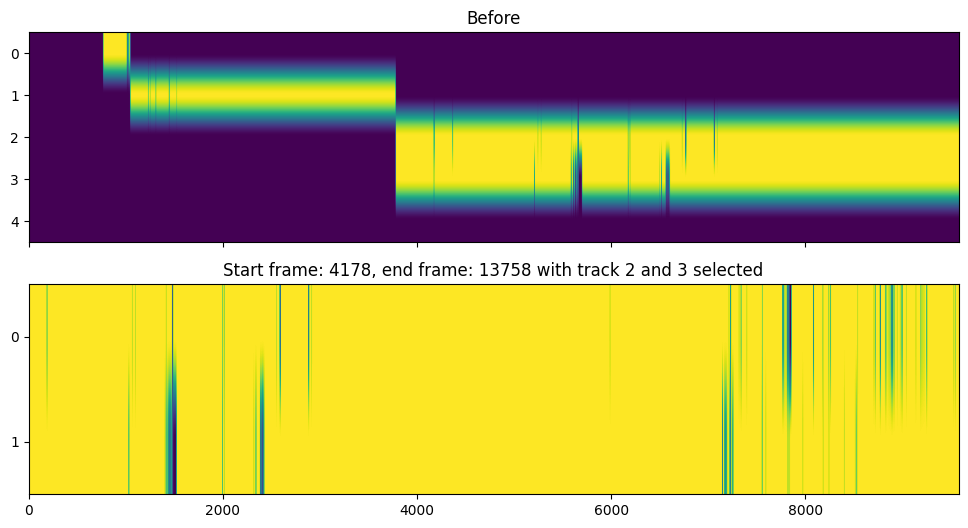

In [63]:
## Single test scenario
# test_path = "/jukebox/falkner/Mae/macrocircuit_context_hormone_experiments/data/intact/3915m/220819/proofread_sleap_output/220819_3915_cdm_home.analysis.h5"
test_path = "/jukebox/falkner/Mae/macrocircuit_context_hormone_experiments/data/intact/103187_1/211107/proofread_sleap_output/211107_1031871_home_balbc.analysis.h5"
with h5py.File(test_path, "r") as f:
    dset_names = list(f.keys())
    locations = f["tracks"][:].T
    point_scores = f["point_scores"][:].T
    track_scores = f["tracking_scores"][:].T
    track_occupancy = f["track_occupancy"][:]
    
fps = 40
start_time = int(60 * fps)

track_len = track_occupancy.shape[1]
possible_pairs = []

for i in range(track_len - 1):
    overlap_idx = np.zeros((track_len,))
    overlap_idx[i] = 1
    overlap_idx[i + 1] = 1

    len_overlap = np.where(np.all(track_occupancy == overlap_idx, axis = 1))[0]
    if len(len_overlap) > 0 and len_overlap[-1] - len_overlap[0] > fps * 200:
        possible_pairs.append((i, len_overlap[0], len_overlap[-1] - len_overlap[0]))

if len(possible_pairs) > 1:
    raise Exception("More than one pair of tracks found")



track_idx = possible_pairs[0][0]
select_idx = np.array([track_idx, track_idx + 1])
start_time = possible_pairs[0][1] + fps * 10
end_time = start_time + possible_pairs[0][2] - fps * 10

print(f"Start frame: {start_time}, end frame: {end_time} with track {track_idx} and {track_idx + 1} selected")

filtered_track = track_occupancy[start_time: end_time, select_idx]
filtered_loc = locations[start_time: end_time, select_idx]
filtered_point_scores = point_scores[start_time: end_time, select_idx]
filtered_track_scores = track_scores[start_time: end_time, select_idx]

fig, axs = plt.subplots(2, 1, figsize = (12, 6), sharex = True)
axs[0].imshow(track_occupancy.T, aspect = "auto")
axs[0].set_title("Before")
axs[0].set_yticks(np.arange(track_len))

axs[1].imshow(filtered_track.T, aspect = "auto")
axs[1].set_title(f"Start frame: {start_time}, end frame: {end_time} with track {track_idx} and {track_idx + 1} selected")
axs[1].set_yticks([0, 1])
plt.show()
plt.close(fig)

In [ ]:
## Archived

# test_path = "/jukebox/falkner/Mae/macrocircuit_context_hormone_experiments/data/intact/103187_1/211107/proofread_sleap_output/211107_1031871_home_balbc.analysis.h5"

# with h5py.File(test_path, "r") as f:
#     dset_names = list(f.keys())
#     locations = f["tracks"][:].T
#     point_scores = f["point_scores"][:].T
#     track_scores = f["tracking_scores"][:].T
#     track_occupancy = f["track_occupancy"][:]

# fig, ax = plt.subplots(figsize = (12, 3))
# ax.imshow(track_occupancy.T, aspect = "auto")
# ax.set_title("Before")

# fps = 40
# start_time = int(60 * fps)

# occ_ratio = np.array([np.where(track_occupancy[:, i] == 0)[0].shape[0] / track_occupancy.shape[0] for i in range(track_occupancy.shape[1])])
# select_idx = np.array([i for i in range(track_occupancy.shape[1]) if i not in np.where(occ_ratio > .9)[0]])

# filtered_track = track_occupancy[start_time:, select_idx]
# filtered_loc = locations[start_time:, select_idx]
# filtered_point_scores = point_scores[start_time:, select_idx]
# filtered_track_scores = track_scores[start_time:, select_idx]

# fig, ax = plt.subplots(figsize = (12, 3))
# ax.imshow(filtered_track.T, aspect = "auto")
# ax.set_title("After")